In [24]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


In [25]:
# 1. Load dataset
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/Dataset/Infrared.csv'
df = pd.read_csv(url)

In [26]:
# 2. Eksplorasi singkat
print("Dataset shape:", df.shape)
print("\nKolom-kolom:")
print(df.columns.tolist())
print("\nTipe data kolom:")
print(df.dtypes)


Dataset shape: (1020, 34)

Kolom-kolom:
['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'aveOralM']

Tipe data kolom:
Gender          object
Age             object
Ethnicity       object
T_atm          float64
Humidity       float64
Distance       float64
T_offset1      float64
Max1R13_1      float64
Max1L13_1      float64
aveAllR13_1    float64
aveAllL13_1    float64
T_RC1          float64
T_RC_Dry1      float64
T_RC_Wet1      float64
T_RC_Max1      float64
T_LC1          float64
T_LC_Dry1      float64
T_LC_Wet1      float64
T_LC_Max1      float64
RCC1           float64
LCC1           float64
canthiMax1     float64
canthi4Max1    float64
T_FHCC1      

In [27]:
# Cek missing values
print("\nJumlah nilai yang hilang pada setiap kolom:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Tampilkan hanya kolom dengan missing values


Jumlah nilai yang hilang pada setiap kolom:
Distance    2
dtype: int64


In [29]:
# 3. Pisahkan kolom numerik dan kategorik
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = ['Gender', 'Age', 'Ethnicity']

In [30]:
# 4. Imputasi nilai yang hilang pada kolom numerik
print("\nMelakukan imputasi untuk nilai yang hilang...")
numeric_imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])


Melakukan imputasi untuk nilai yang hilang...


In [31]:
# 5. Encoding kolom kategorikal menggunakan One-Hot Encoding
print("Melakukan one-hot encoding untuk kolom kategorikal...")
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

Melakukan one-hot encoding untuk kolom kategorikal...


In [32]:
# 6. Cek kembali untuk memastikan tidak ada nilai yang hilang
print("\nMemastikan tidak ada nilai yang hilang setelah imputasi:")
print(df_encoded.isnull().sum().sum())


Memastikan tidak ada nilai yang hilang setelah imputasi:
0


In [33]:
# 7. Persiapkan fitur dan target
X = df_encoded.drop('aveOralM', axis=1)
y = df_encoded['aveOralM']

In [34]:
# 8. Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Jumlah data training: {X_train.shape[0]}")
print(f"Jumlah data testing: {X_test.shape[0]}")

Jumlah data training: 816
Jumlah data testing: 204


In [35]:
# 9. Fungsi untuk evaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Fit model
    model.fit(X_train, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Evaluasi
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2,
        'CV R² (mean)': cv_scores.mean(),
        'CV R² (std)': cv_scores.std()
    }

In [36]:
# 10. Baseline Model - Decision Tree
print("\n1. BASELINE MODEL - DECISION TREE")
dt_model = DecisionTreeRegressor(random_state=42)
dt_results = evaluate_model(dt_model, X_train, X_test, y_train, y_test)
print("Decision Tree Results:")
for metric, value in dt_results.items():
    print(f"{metric}: {value:.4f}")


1. BASELINE MODEL - DECISION TREE
Decision Tree Results:
MSE: 0.1154
RMSE: 0.3397
R²: 0.4521
CV R² (mean): 0.4277
CV R² (std): 0.1748



2. FEATURE SELECTION


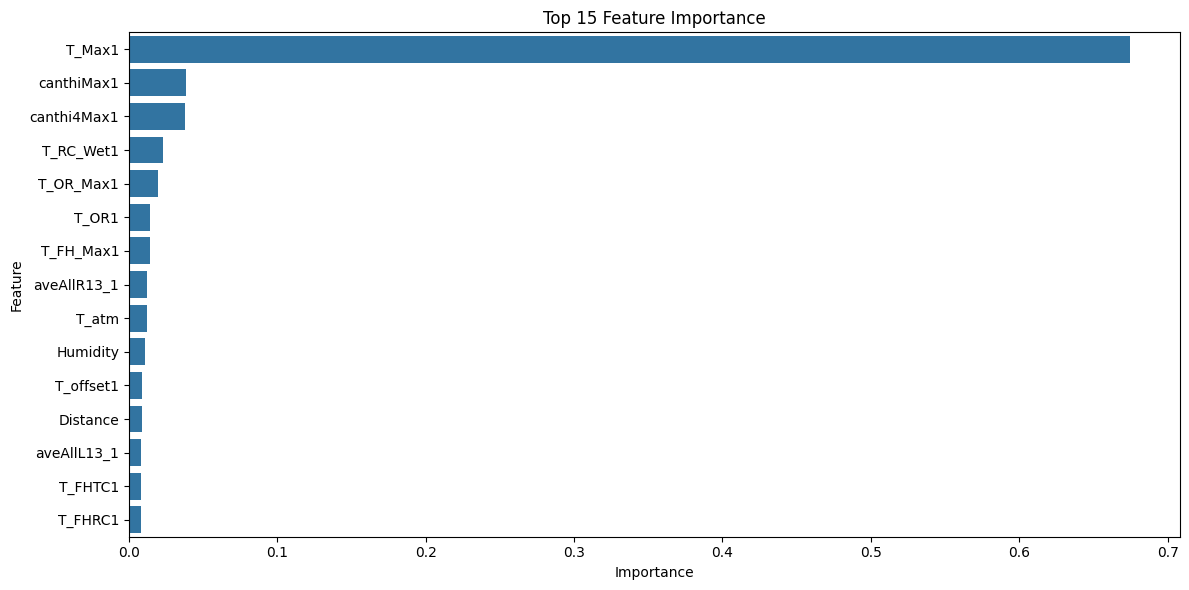

Jumlah fitur sebelum seleksi: 46
Jumlah fitur setelah seleksi: 4
Fitur yang terpilih:
['T_RC_Wet1', 'canthiMax1', 'canthi4Max1', 'T_Max1']


In [38]:
# 11. Feature Selection
print("\n2. FEATURE SELECTION")
# Gunakan RandomForest untuk feature selection
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_selector.fit(X_train, y_train)

# Dapatkan feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_selector.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualisasi top 15 feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

# Pilih fitur dengan threshold tertentu
selector = SelectFromModel(rf_selector, threshold='mean')
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Jumlah fitur yang terpilih
selected_features = X.columns[selector.get_support()]
print(f"Jumlah fitur sebelum seleksi: {X.shape[1]}")
print(f"Jumlah fitur setelah seleksi: {len(selected_features)}")
print("Fitur yang terpilih:")
print(selected_features.tolist())

In [39]:
# 12. Model dengan Feature Selection
print("\n3. MODEL DENGAN FEATURE SELECTION")
dt_selected = DecisionTreeRegressor(random_state=42)
dt_selected_results = evaluate_model(dt_selected, X_train_selected, X_test_selected, y_train, y_test)
print("Decision Tree with Selected Features Results:")
for metric, value in dt_selected_results.items():
    print(f"{metric}: {value:.4f}")


3. MODEL DENGAN FEATURE SELECTION
Decision Tree with Selected Features Results:
MSE: 0.1104
RMSE: 0.3323
R²: 0.4758
CV R² (mean): 0.4277
CV R² (std): 0.1748


In [40]:
# 13. Ensemble Models
print("\n4. ENSEMBLE MODELS")

# Random Forest
print("\n4.1 Random Forest")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_results = evaluate_model(rf_model, X_train, X_test, y_train, y_test)
print("Random Forest Results:")
for metric, value in rf_results.items():
    print(f"{metric}: {value:.4f}")

# Gradient Boosting
print("\n4.2 Gradient Boosting")
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_results = evaluate_model(gb_model, X_train, X_test, y_train, y_test)
print("Gradient Boosting Results:")
for metric, value in gb_results.items():
    print(f"{metric}: {value:.4f}")


4. ENSEMBLE MODELS

4.1 Random Forest
Random Forest Results:
MSE: 0.0571
RMSE: 0.2389
R²: 0.7290
CV R² (mean): 0.7075
CV R² (std): 0.0818

4.2 Gradient Boosting
Gradient Boosting Results:
MSE: 0.0489
RMSE: 0.2211
R²: 0.7679
CV R² (mean): 0.7105
CV R² (std): 0.0720


In [41]:
# 14. Hyperparameter Tuning untuk model terbaik
print("\n5. HYPERPARAMETER TUNING")
# Berdasarkan hasil di atas, gunakan model dengan performa terbaik (misalnya Gradient Boosting)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

print("Melakukan grid search untuk hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")


5. HYPERPARAMETER TUNING
Melakukan grid search untuk hyperparameter tuning...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 50}
Best CV score: 0.7290


In [43]:
# 15. Final Model dengan parameter terbaik
print("\n6. FINAL MODEL")
best_gb = grid_search.best_estimator_
best_gb_results = evaluate_model(best_gb, X_train, X_test, y_train, y_test)
print("Tuned Gradient Boosting Results:")
for metric, value in best_gb_results.items():
    print(f"{metric}: {value:.4f}")


6. FINAL MODEL
Tuned Gradient Boosting Results:
MSE: 0.0491
RMSE: 0.2215
R²: 0.7670
CV R² (mean): 0.7162
CV R² (std): 0.0697


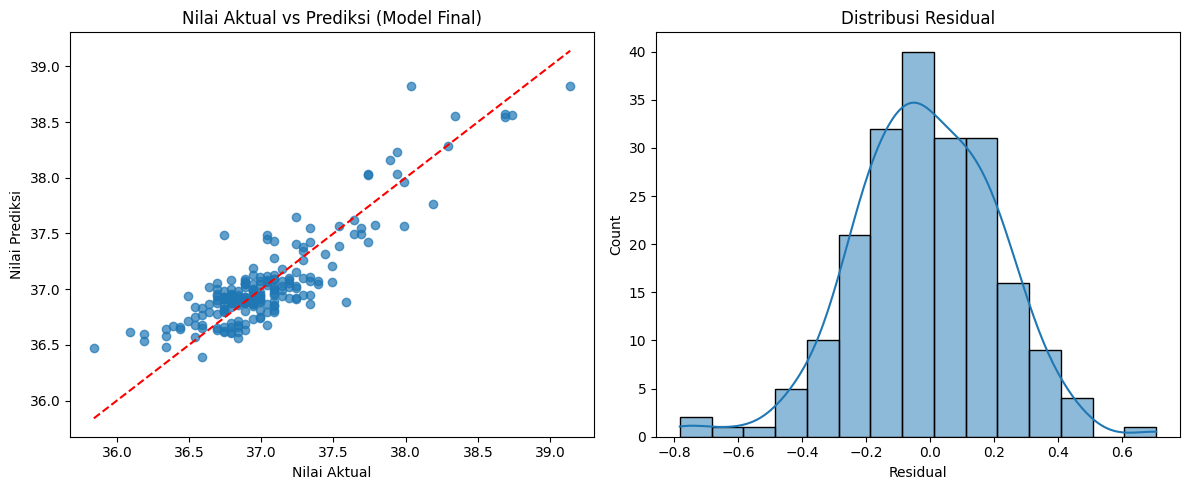

In [44]:
# 16. Visualisasi hasil model
y_pred_final = best_gb.predict(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.title('Nilai Aktual vs Prediksi (Model Final)')

plt.subplot(1, 2, 2)
residuals = y_test - y_pred_final
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.title('Distribusi Residual')
plt.tight_layout()
plt.show()



7. PERBANDINGAN SEMUA MODEL
                     Model       MSE      RMSE        R²  CV R² (mean)
0            Decision Tree  0.115380  0.339676  0.452065      0.427663
1   DT + Feature Selection  0.110392  0.332253  0.475751      0.427663
2            Random Forest  0.057074  0.238902  0.728956      0.707479
3        Gradient Boosting  0.048874  0.221075  0.767899      0.710491
4  Tuned Gradient Boosting  0.049073  0.221525  0.766953      0.716157


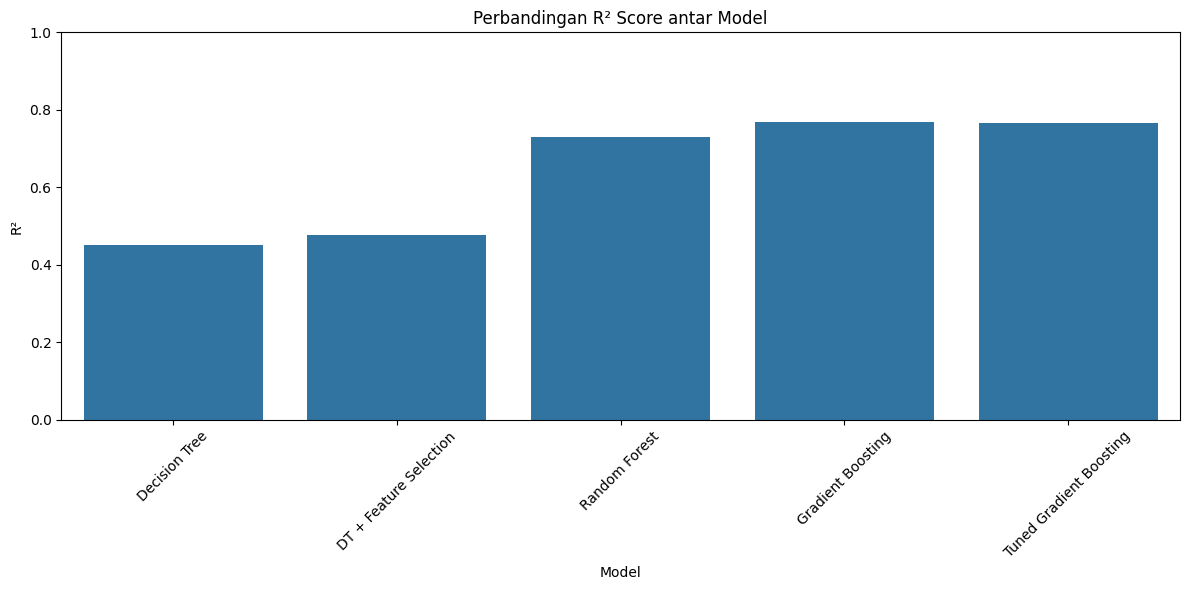

In [45]:
# 17. Perbandingan semua model
print("\n7. PERBANDINGAN SEMUA MODEL")
models = {
    'Decision Tree': dt_results,
    'DT + Feature Selection': dt_selected_results,
    'Random Forest': rf_results,
    'Gradient Boosting': gb_results,
    'Tuned Gradient Boosting': best_gb_results
}

metrics_df = pd.DataFrame({
    'Model': list(models.keys()),
    'MSE': [models[model]['MSE'] for model in models],
    'RMSE': [models[model]['RMSE'] for model in models],
    'R²': [models[model]['R²'] for model in models],
    'CV R² (mean)': [models[model]['CV R² (mean)'] for model in models]
})

print(metrics_df)

# Visualisasi perbandingan R²
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='R²', data=metrics_df)
plt.title('Perbandingan R² Score antar Model')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Mean Squared Error (MSE)
Mean Squared Error (MSE) adalah metrik yang digunakan untuk mengukur rata-rata kuadrat dari selisih antara nilai sebenarnya (y_true) dan nilai prediksi (y_pred). Rumus MSE:

\[ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 \]

Semakin kecil nilai MSE, semakin baik model dalam memprediksi nilai yang benar.



## Root Mean Squared Error (RMSE)
Root Mean Squared Error (RMSE) adalah akar kuadrat dari MSE. Rumusnya adalah:

\[ RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} \]

RMSE memiliki satuan yang sama dengan data asli, sehingga lebih mudah untuk diinterpretasikan dibandingkan MSE.



## R-squared (R²)
R-squared (R²) adalah metrik yang digunakan untuk mengukur seberapa baik model menjelaskan variasi dalam data. Rumusnya:

\[ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} \]

Di mana:
- \( SS_{res} = \sum (y_i - \hat{y}_i)^2 \) adalah jumlah kuadrat residual (error).
- \( SS_{tot} = \sum (y_i - \bar{y})^2 \) adalah jumlah kuadrat total.

Nilai R² berkisar antara 0 hingga 1. Semakin mendekati 1, semakin baik model dalam menjelaskan variasi data.